### **Importing Libraries**


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import torch
import torch.nn as nn
from torchmetrics.classification import (
    BinaryRecall,
    BinaryAccuracy,
    BinaryF1Score,
    BinaryPrecision,
)

### **Loading the Dataset**


In [5]:
dataset = pd.read_csv("diabetes_data.csv")
dataset

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
70688,10.0,1.0,1.0,1.0,29.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
70689,13.0,0.0,1.0,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,15.0,0.0,1.0,0.0,1.0,1.0
70690,11.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0


### **Check for number of records and columns**


In [6]:
print(f"The dataset has {dataset.shape[0]} rows and {dataset.shape[1]} columns")

The dataset has 70692 rows and 18 columns


### **Check for null values**


In [7]:
dataset.isnull().sum()

Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64

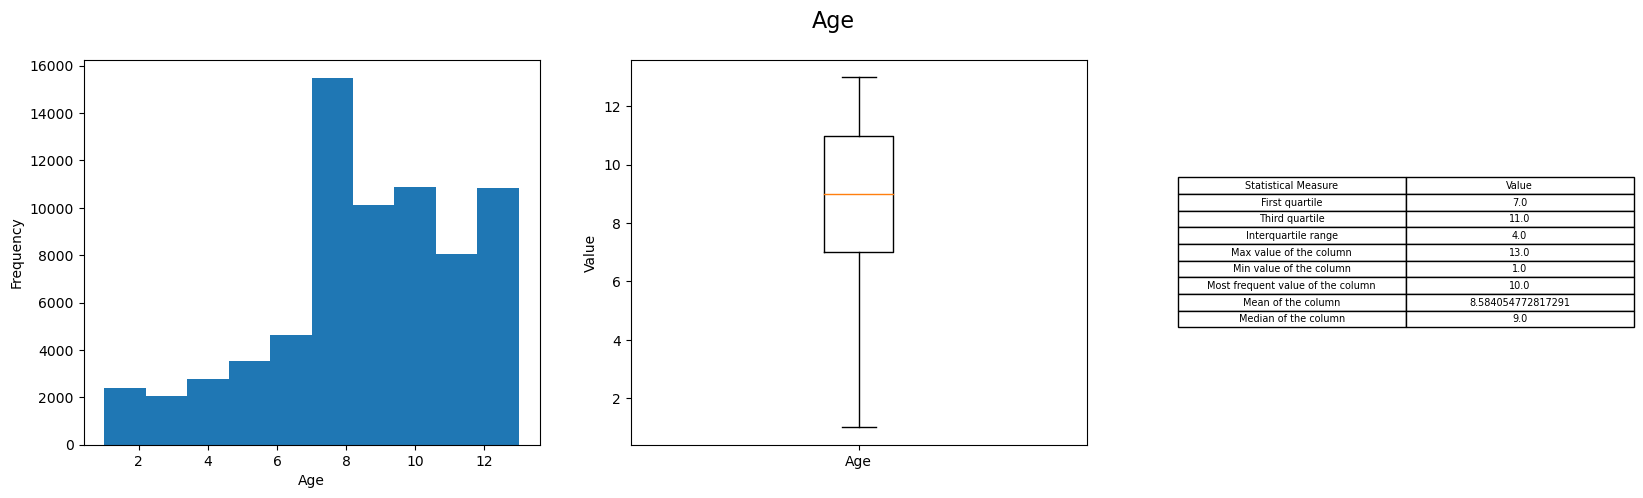

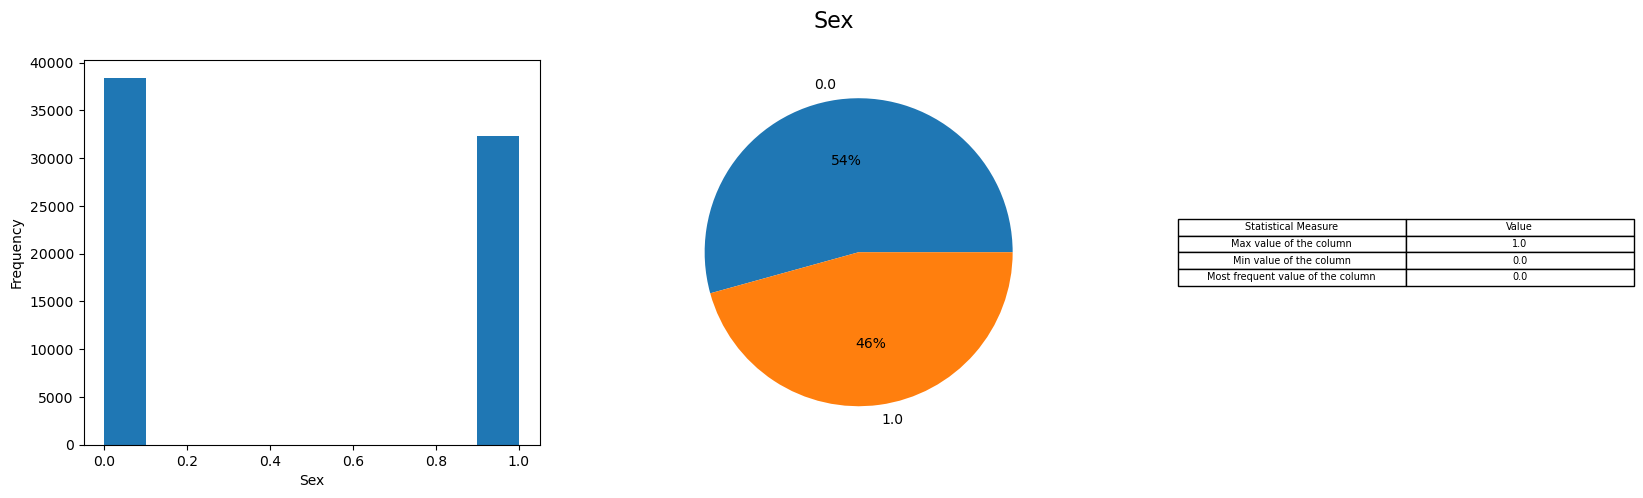

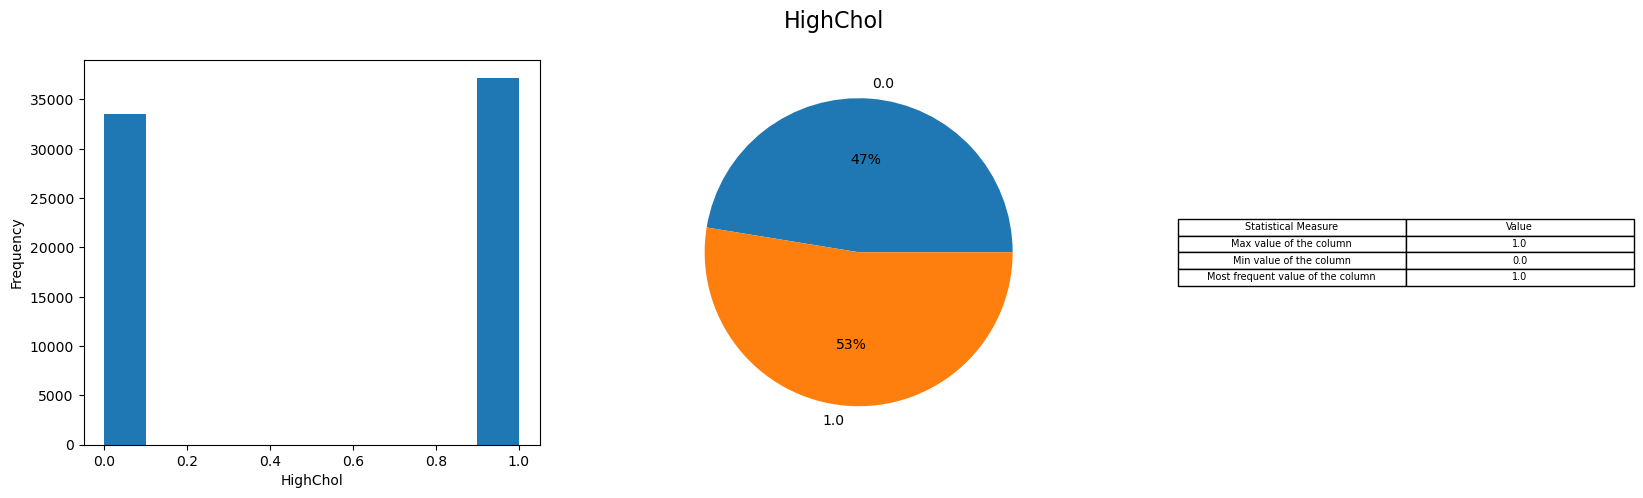

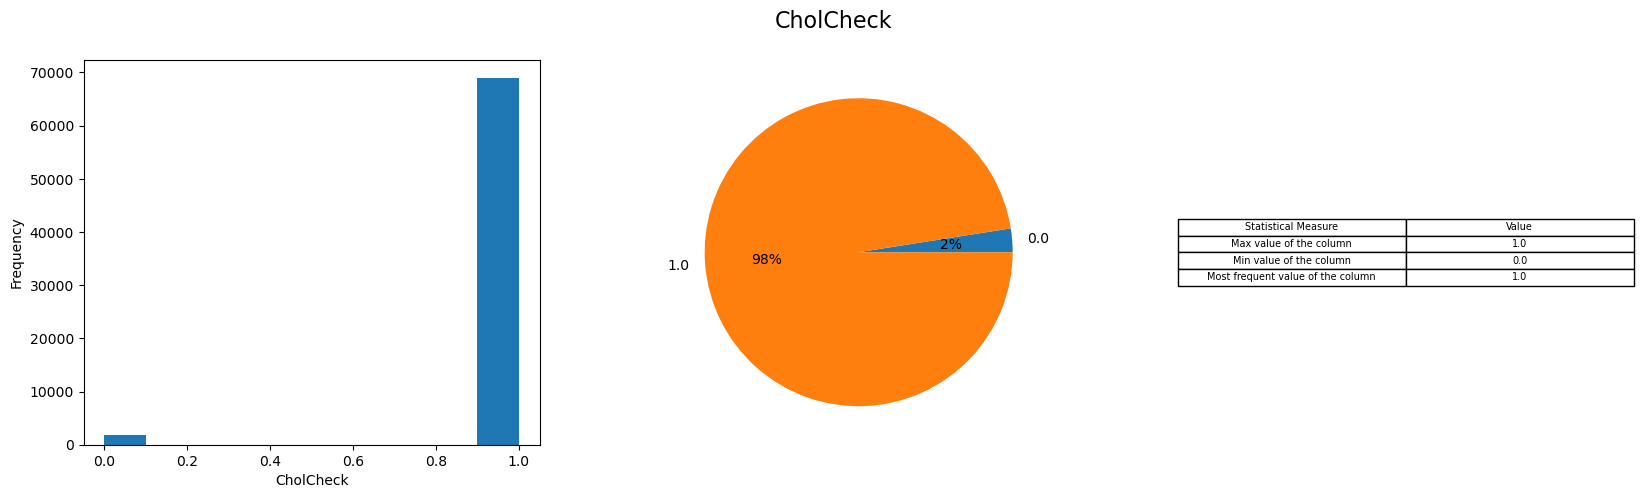

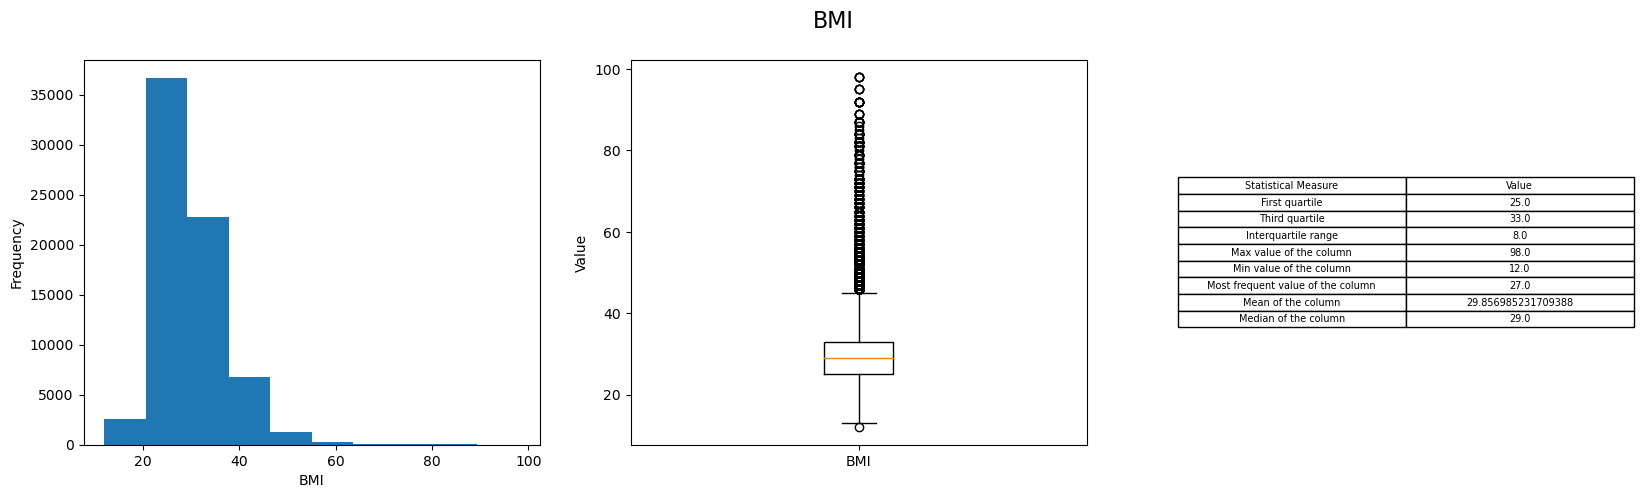

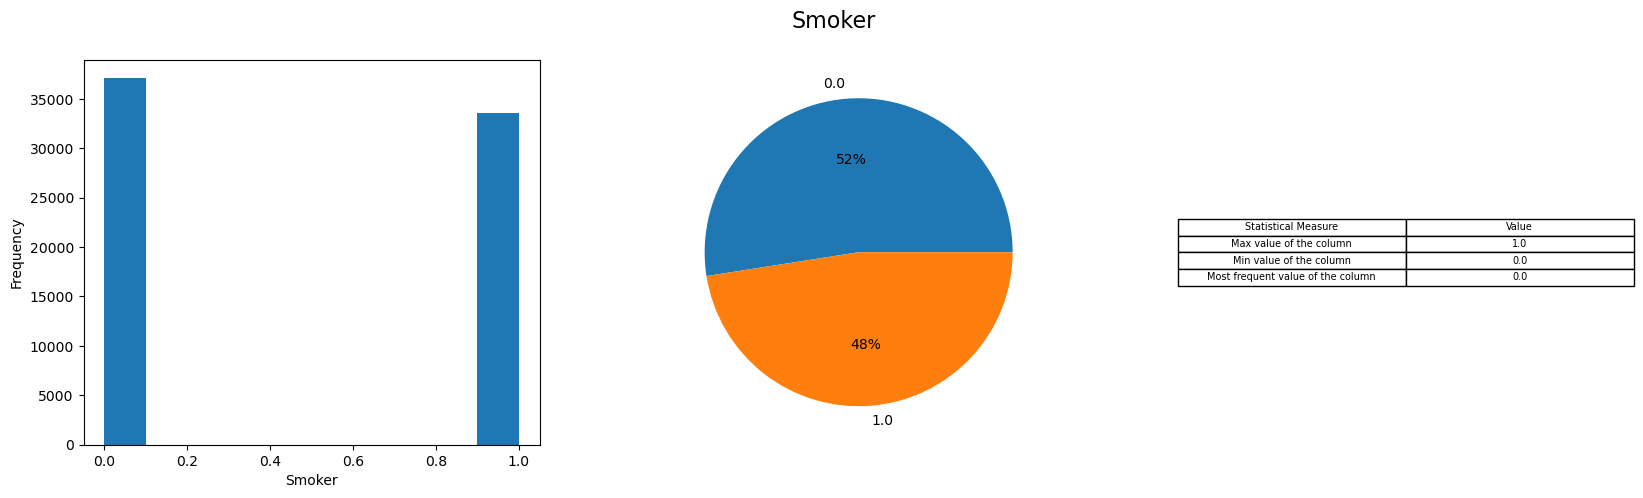

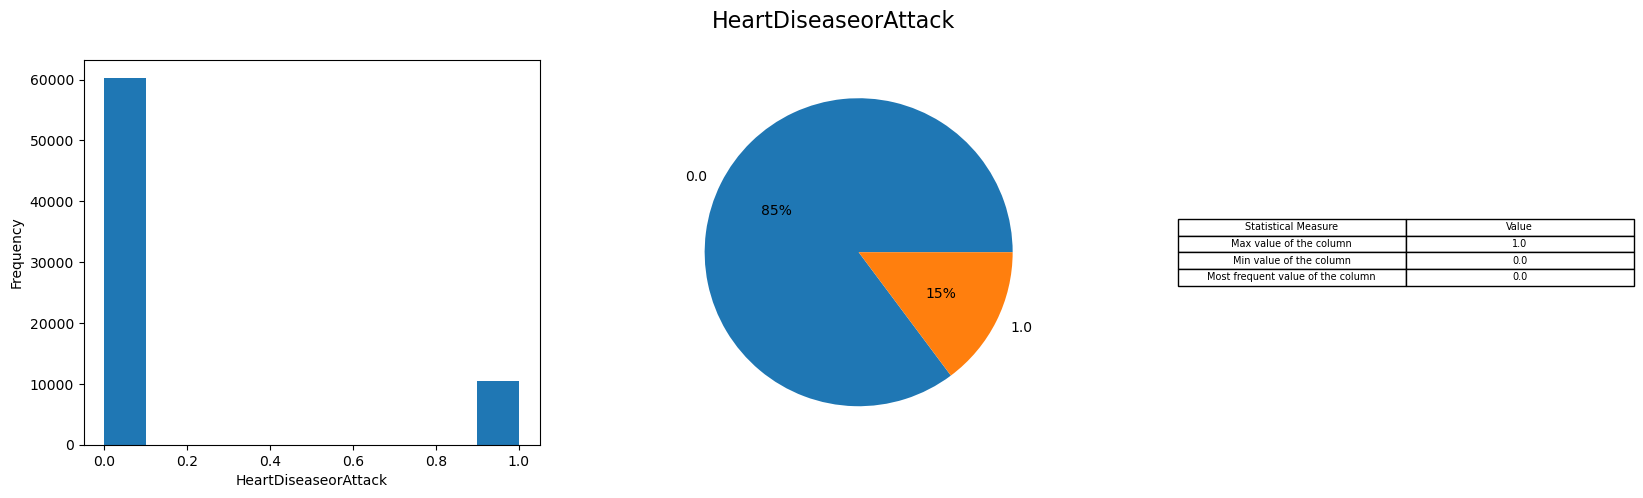

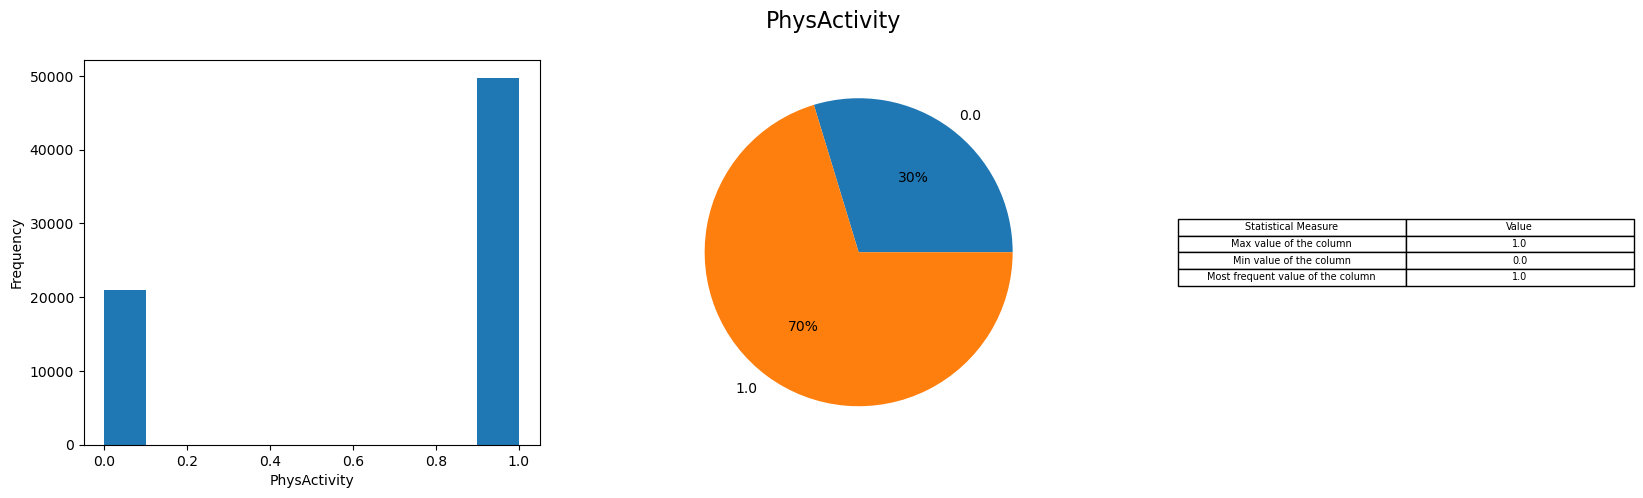

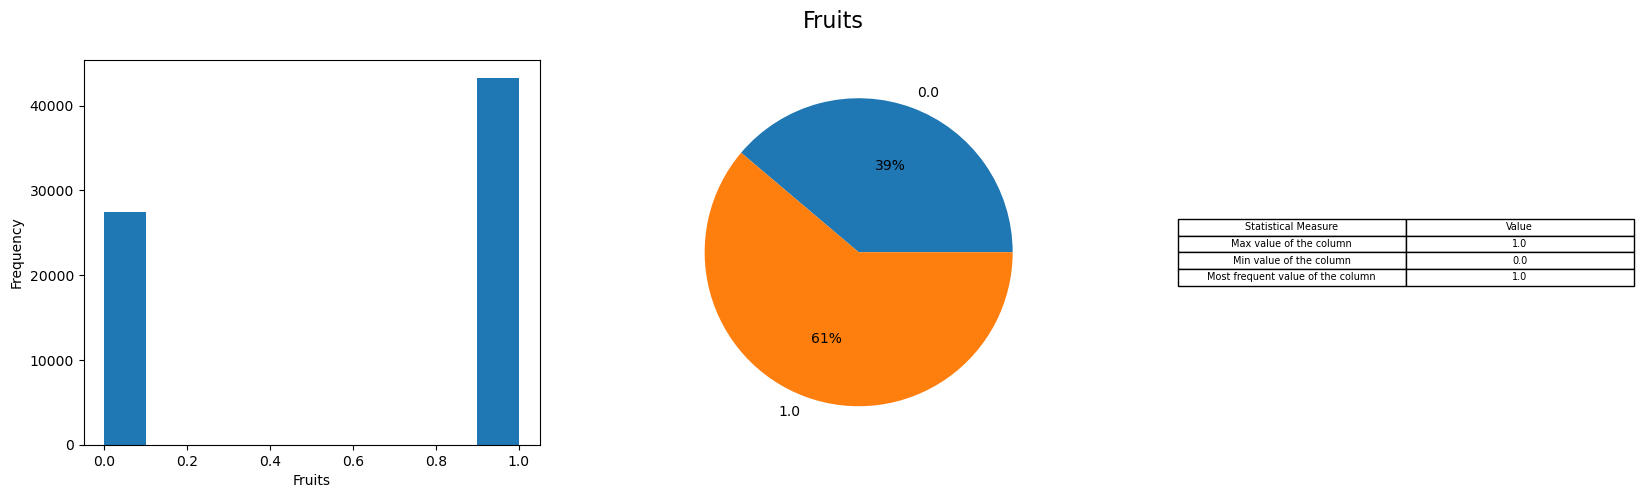

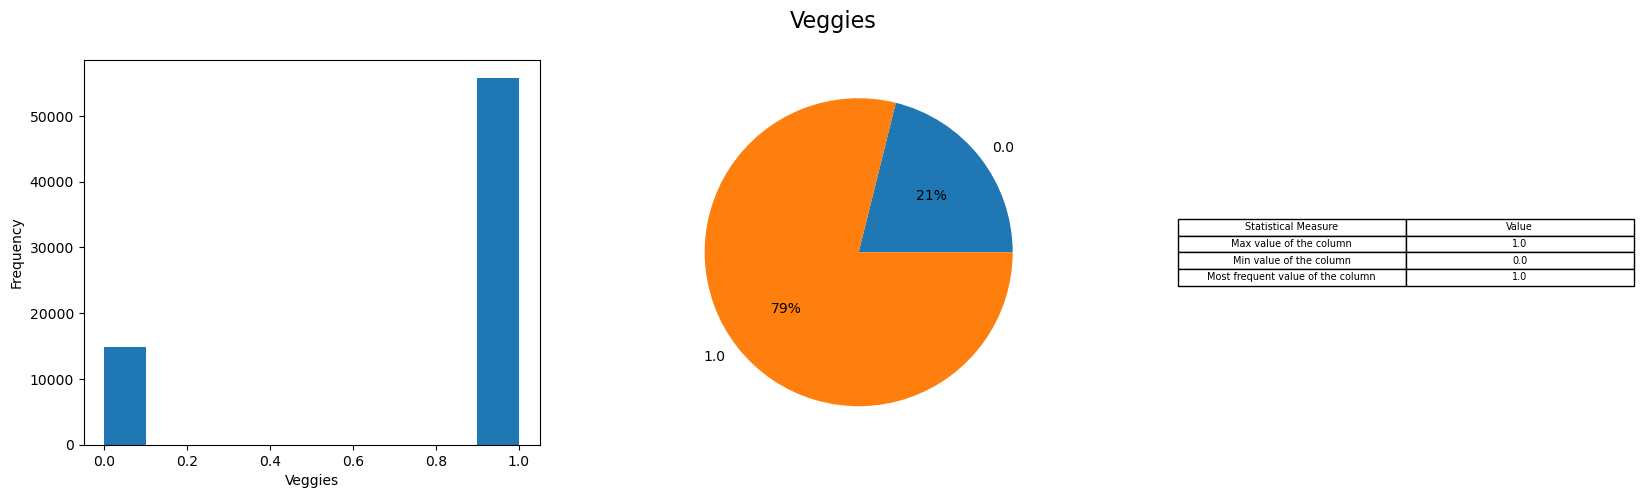

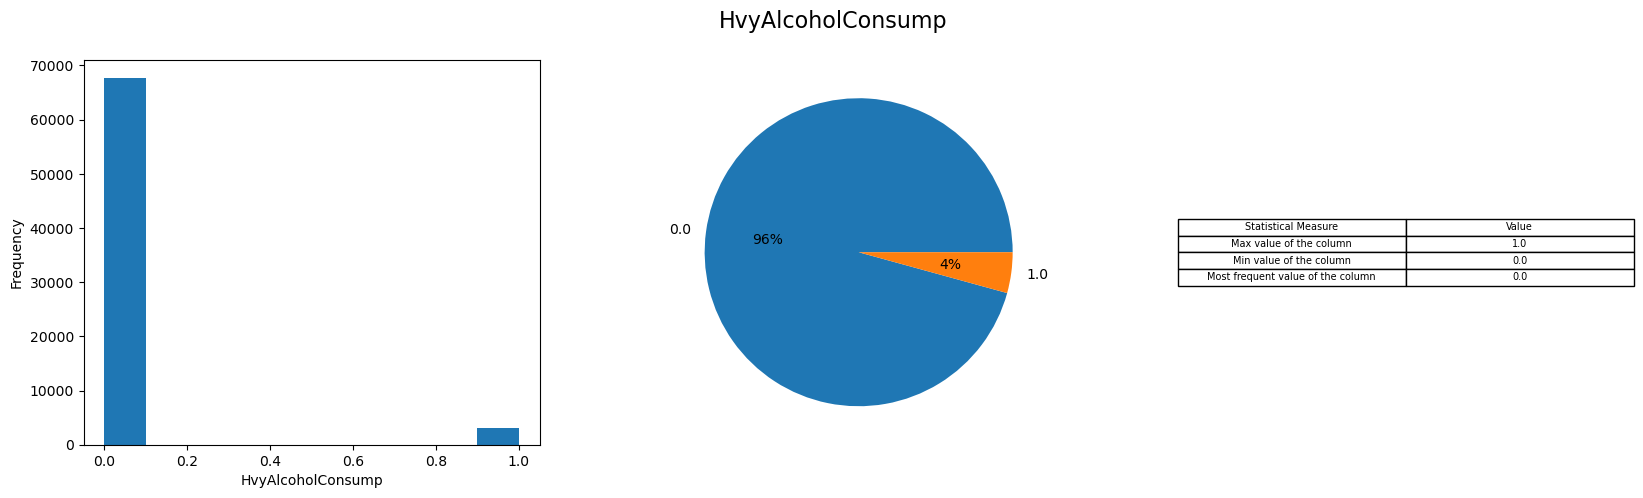

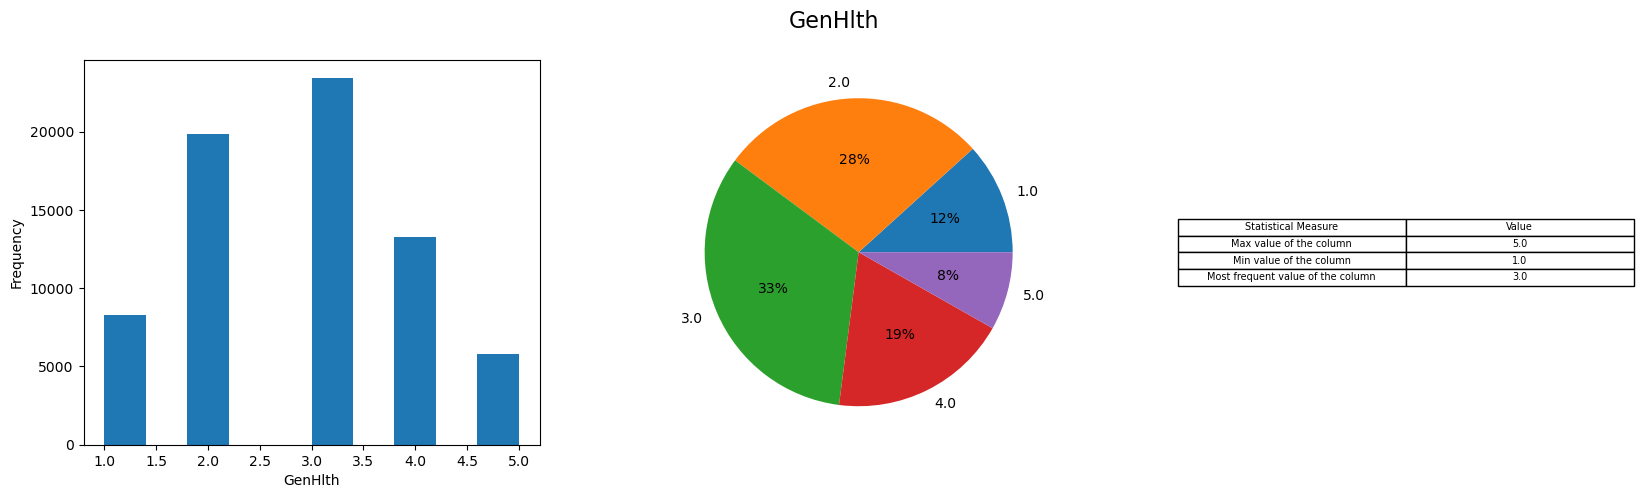

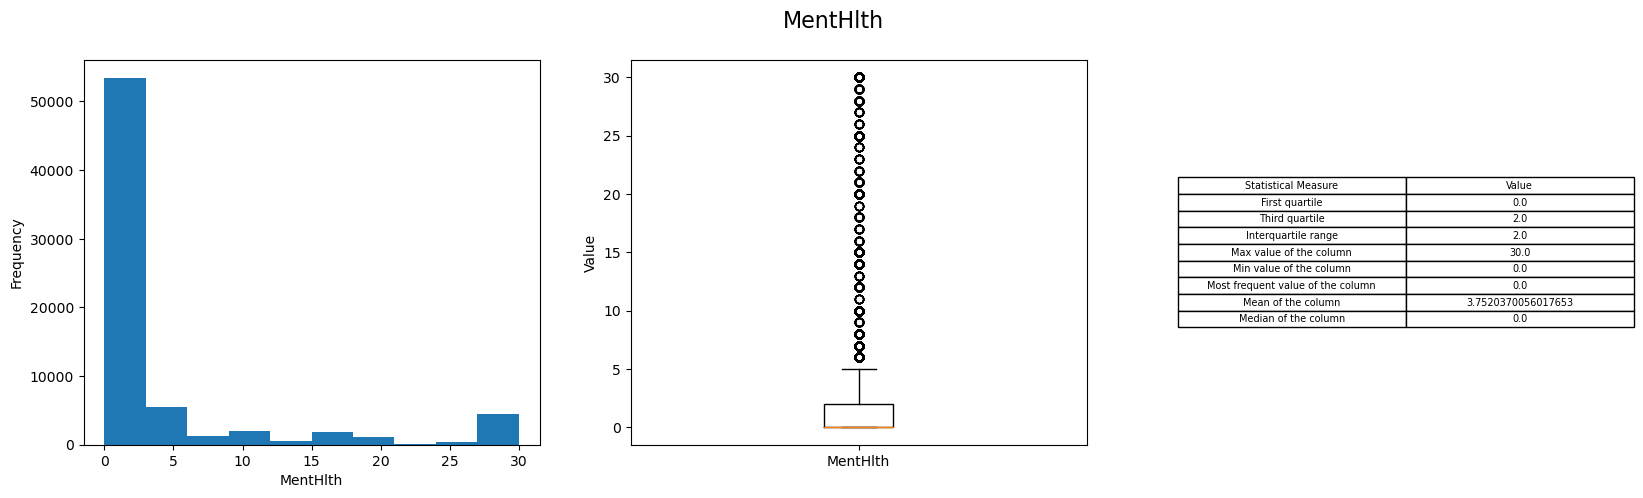

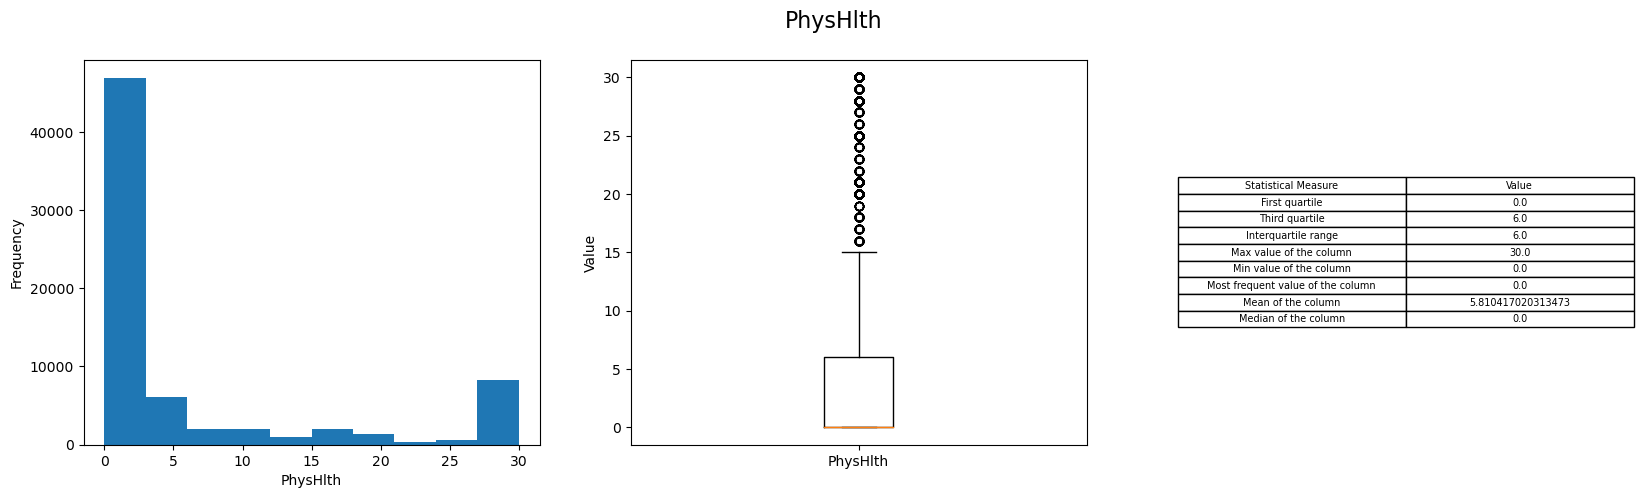

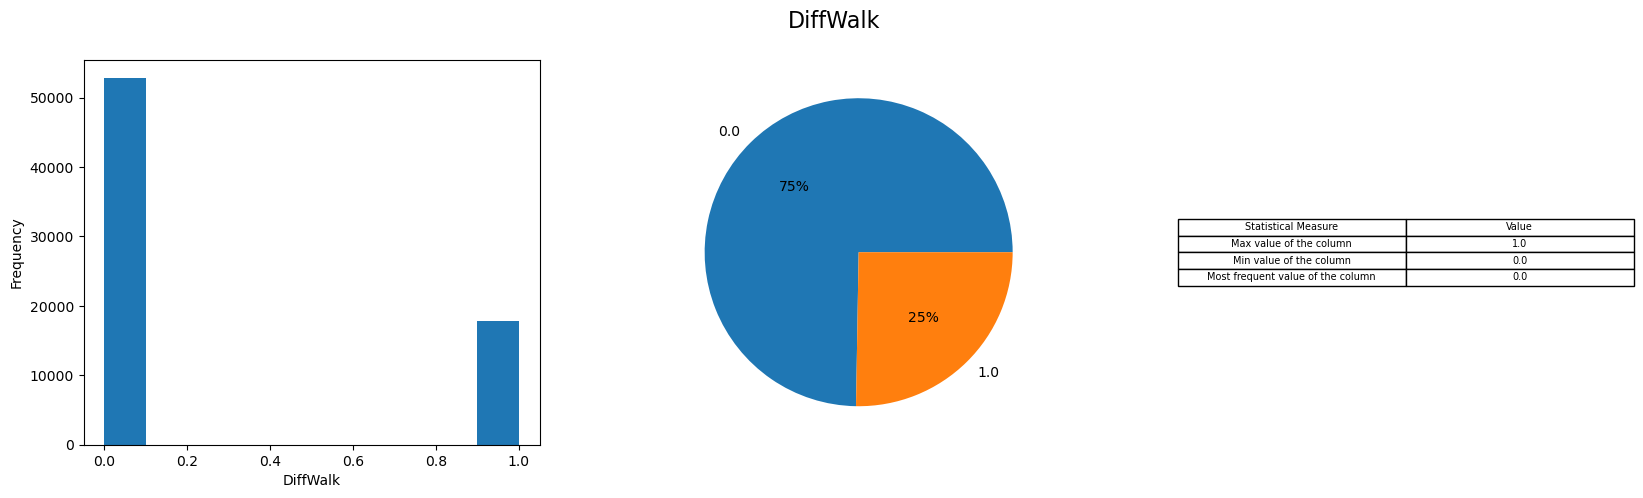

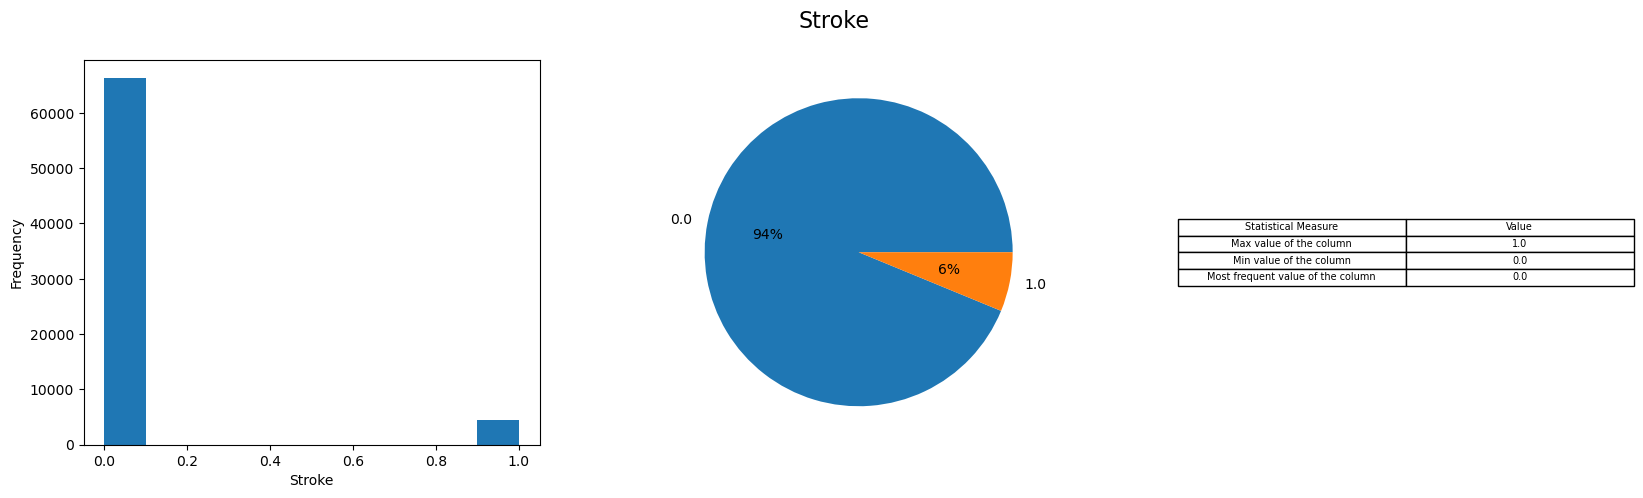

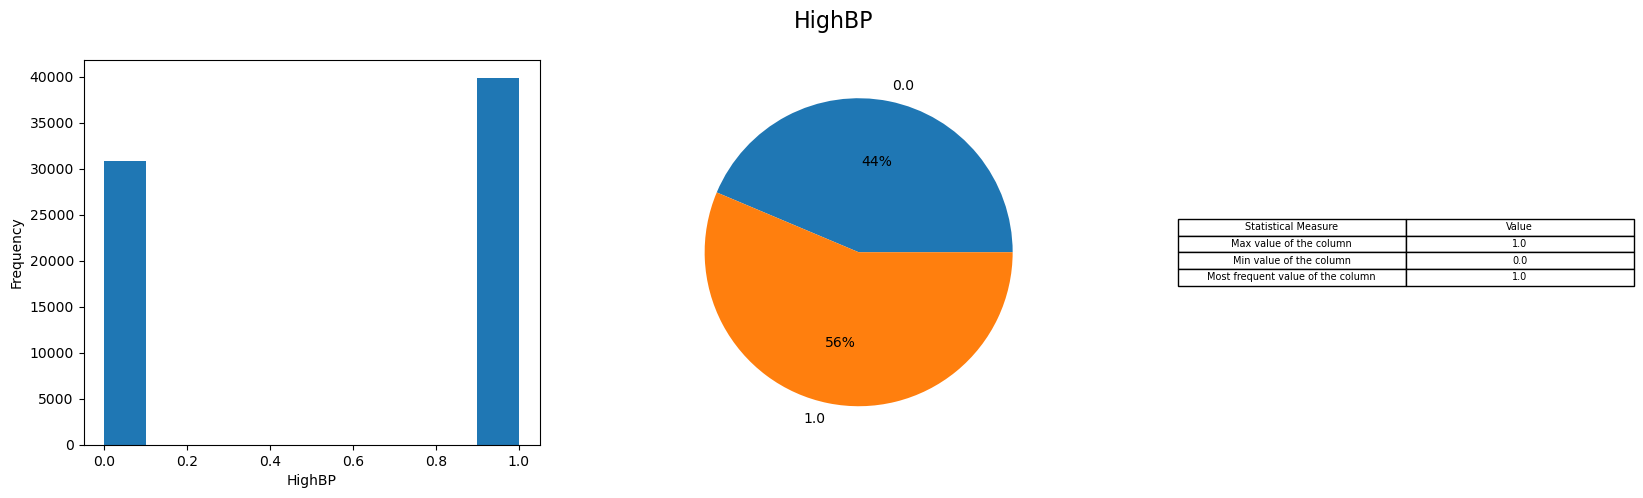

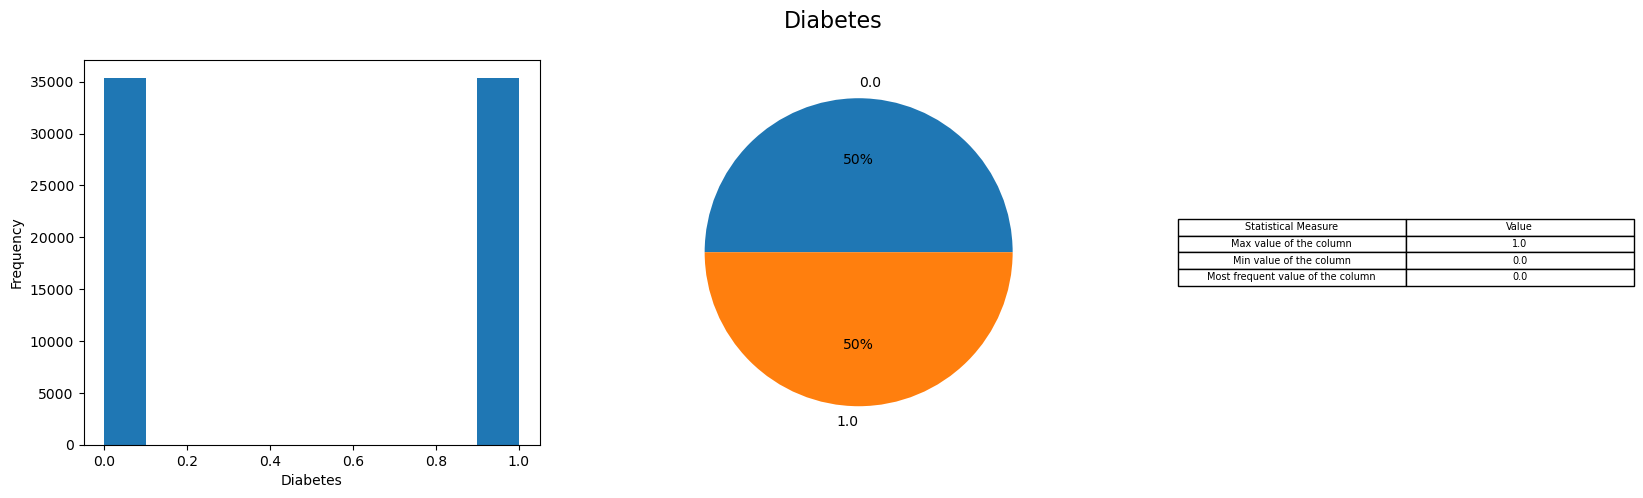

In [8]:
import pandas as pd


def numerical_data_analysis(column_name, dataset):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(column_name, fontsize=16)

    # Histogram
    axs[0].hist(dataset[column_name], bins=10)
    axs[0].set_xlabel(column_name)
    axs[0].set_ylabel("Frequency")

    if dataset[column_name].nunique() > 10:
        # Boxplot
        axs[1].boxplot(dataset[column_name])
        axs[1].set_xticklabels([column_name])
        axs[1].set_ylabel("Value")

        # Statistical measures
        Q3 = np.quantile(dataset[column_name], 0.75)
        Q1 = np.quantile(dataset[column_name], 0.25)
        IQR = Q3 - Q1
        stats_table = pd.DataFrame(
            {
                "Statistical Measure": [
                    "First quartile",
                    "Third quartile",
                    "Interquartile range",
                    "Max value of the column",
                    "Min value of the column",
                    "Most frequent value of the column",
                    "Mean of the column",
                    "Median of the column",
                ],
                "Value": [
                    Q1,
                    Q3,
                    IQR,
                    dataset[column_name].max(),
                    dataset[column_name].min(),
                    dataset[column_name].mode()[0],
                    dataset[column_name].mean(),
                    dataset[column_name].median(),
                ],
            }
        )
        axs[2].axis("off")
        axs[2].table(
            cellText=stats_table.values,
            colLabels=stats_table.columns,
            loc="center",
            fontsize=30,
            cellLoc="center",
        )
    else:
        # Pie chart
        axs[1].pie(
            dataset[column_name].value_counts().sort_index(),
            labels=np.arange(
                dataset[column_name].min(), dataset[column_name].max() + 1
            ),
            autopct="%1.0f%%",
        )

        # Statistical measures
        stats_table = pd.DataFrame(
            {
                "Statistical Measure": [
                    "Max value of the column",
                    "Min value of the column",
                    "Most frequent value of the column",
                ],
                "Value": [
                    dataset[column_name].max(),
                    dataset[column_name].min(),
                    dataset[column_name].mode()[0],
                ],
            }
        )
        axs[2].axis("off")
        axs[2].table(
            cellText=stats_table.values,
            colLabels=stats_table.columns,
            loc="center",
            fontsize=30,
            cellLoc="center",
        )

    plt.show()


def exploratory_data_analysis(data):
    if len(data) != 0:
        for column in data.columns:
            numerical_data_analysis(column_name=column, dataset=data)
            print("\n\n\n\n")


exploratory_data_analysis(dataset)

### **Process the dataset by separating the features (X) and the target variable (y).**


In [9]:
X, y = dataset.drop("Diabetes", axis=1).values, dataset[["Diabetes"]].values.reshape(
    -1,
)

print(f"The features matrix has {X.shape[0]} rows and {X.shape[1]} columns")
print(f"The target vector has {y.shape[0]} rows")

The features matrix has 70692 rows and 17 columns
The target vector has 70692 rows


### **Split the dataset into training, validation and test sets.**

- Training set: 80%
- Validation set: 10%
- Test set: 10%


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_validation, y_test, y_validation = train_test_split(
    X_test, y_test, test_size=0.5
)

### **1- Train KNN model with different values of K and find the accuracy for each K value.**


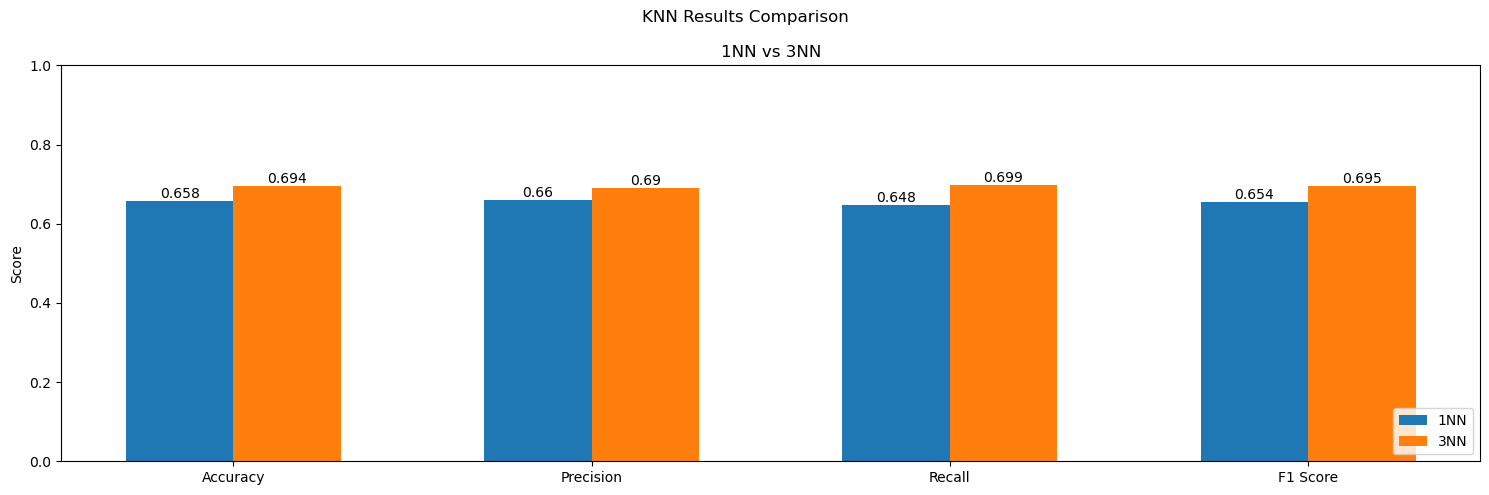

In [11]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, y_train)

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)


# Calculate metrics for 1NN
knn_1_accuracy = accuracy_score(y_validation, knn_1.predict(X_validation))
knn_1_precision = precision_score(y_validation, knn_1.predict(X_validation))
knn_1_recall = recall_score(y_validation, knn_1.predict(X_validation))
knn_1_f1 = f1_score(y_validation, knn_1.predict(X_validation))

# Calculate metrics for 3NN
knn_3_accuracy = accuracy_score(y_validation, knn_3.predict(X_validation))
knn_3_precision = precision_score(y_validation, knn_3.predict(X_validation))
knn_3_recall = recall_score(y_validation, knn_3.predict(X_validation))
knn_3_f1 = f1_score(y_validation, knn_3.predict(X_validation))

# Plotting
results_fig, results_ax = plt.subplots(1, 1, figsize=(15, 5))
results_fig.suptitle("KNN Results Comparison")
results_ax.bar(
    np.arange(4),
    [knn_1_accuracy, knn_1_precision, knn_1_recall, knn_1_f1],
    width=0.3,
    label="1NN",
)
results_ax.bar(
    np.arange(4) + 0.3,
    [knn_3_accuracy, knn_3_precision, knn_3_recall, knn_3_f1],
    width=0.3,
    label="3NN",
)
results_ax.set_xticks(np.arange(4) + 0.3 / 2)
results_ax.set_xticklabels(["Accuracy", "Precision", "Recall", "F1 Score"])
results_ax.set_ylabel("Score")
results_ax.set_ylim([0, 1])
results_ax.set_title("1NN vs 3NN")
results_ax.legend(loc="lower right")

results_ax.text(0, knn_1_accuracy, round(knn_1_accuracy, 3), ha="center", va="bottom")
results_ax.text(1, knn_1_precision, round(knn_1_precision, 3), ha="center", va="bottom")
results_ax.text(2, knn_1_recall, round(knn_1_recall, 3), ha="center", va="bottom")
results_ax.text(3, knn_1_f1, round(knn_1_f1, 3), ha="center", va="bottom")
results_ax.text(0.3, knn_3_accuracy, round(knn_3_accuracy, 3), ha="center", va="bottom")
results_ax.text(
    1.3, knn_3_precision, round(knn_3_precision, 3), ha="center", va="bottom"
)
results_ax.text(2.3, knn_3_recall, round(knn_3_recall, 3), ha="center", va="bottom")
results_ax.text(3.3, knn_3_f1, round(knn_3_f1, 3), ha="center", va="bottom")

plt.tight_layout()
plt.show()

### **2- Train XGBoost model with different values of hyperparameters and find the best hyperparameter values.**


#### **The hyperparameters to be tuned are:**


In [12]:
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
}

#### **Model Training**


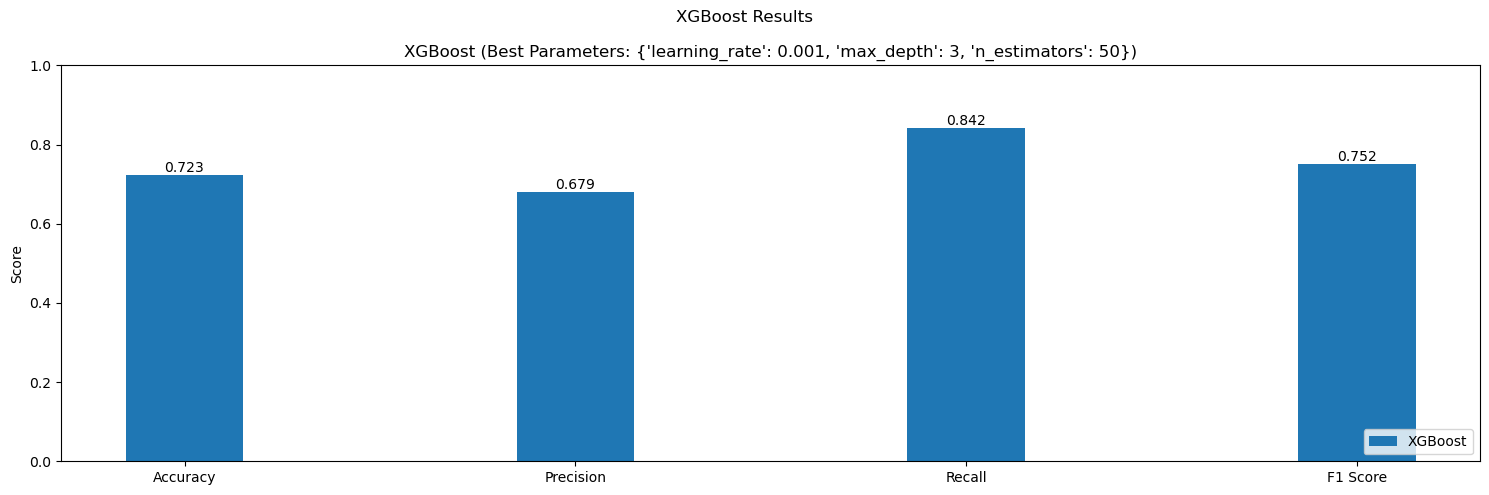

In [13]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_classifier, param_grid=param_grid, n_jobs=-1, scoring="recall"
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
xgb_accuracy = accuracy_score(y_validation, best_model.predict(X_validation))
xgb_precision = precision_score(y_validation, best_model.predict(X_validation))
xgb_recall = recall_score(y_validation, best_model.predict(X_validation))
xgb_f1 = f1_score(y_validation, best_model.predict(X_validation))

# Plotting
results_fig, results_ax = plt.subplots(1, 1, figsize=(15, 5))
results_fig.suptitle("XGBoost Results")
results_ax.bar(
    np.arange(4),
    [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
    width=0.3,
    label=f"XGBoost",
)
results_ax.set_xticks(np.arange(4))
results_ax.set_xticklabels(["Accuracy", "Precision", "Recall", "F1 Score"])
results_ax.set_ylabel("Score")
results_ax.set_ylim([0, 1])
results_ax.set_title(f"XGBoost (Best Parameters: {best_params})")
results_ax.legend(loc="lower right")

results_ax.text(0, xgb_accuracy, round(xgb_accuracy, 3), ha="center", va="bottom")
results_ax.text(1, xgb_precision, round(xgb_precision, 3), ha="center", va="bottom")
results_ax.text(2, xgb_recall, round(xgb_recall, 3), ha="center", va="bottom")
results_ax.text(3, xgb_f1, round(xgb_f1, 3), ha="center", va="bottom")

plt.tight_layout()
plt.show()

### **3- Train ANN models**


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
print(f"Using {device} device")

Using cuda device


#### **Create three feed-forward neural network models**


In [15]:
class ANN_model_1(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units * 2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 2, out_features=out_shape),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.layer_stack(X)


class ANN_model_2(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units * 4),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 4),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 4, out_features=out_shape),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.layer_stack(X)


class ANN_model_3(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units * 4),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 8),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 8, out_features=hidden_units * 8),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units * 8, out_features=out_shape),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.layer_stack(X)

#### **Initialize the ANN models**


In [16]:
model_1 = ANN_model_1(X_train.shape[1], 1, 10).to(device)
model_2 = ANN_model_2(X_train.shape[1], 1, 10).to(device)
model_3 = ANN_model_3(X_train.shape[1], 1, 10).to(device)

#### **Train the ANN models**


In [17]:
epochs = 200
accuracies: float = []
precisions: float = []
recalls: float = []
f1_scores: float = []

for model in [model_1, model_2, model_3]:
    torch.manual_seed(50)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(
        device
    )
    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train_tensor)
        loss = loss_function(y_pred, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32).to(device)
    y_validation_tensor = torch.tensor(
        y_validation.reshape(-1, 1), dtype=torch.float32
    ).to(device)

    with torch.inference_mode():
        model.eval()
        y_pred = model(X_validation_tensor)
        accuracy = BinaryAccuracy().to(device)
        precision = BinaryPrecision().to(device)
        recall = BinaryRecall().to(device)
        f1 = BinaryF1Score().to(device)
        accuracies.append(accuracy(y_pred, y_validation_tensor).item())
        precisions.append(precision(y_pred, y_validation_tensor).item())
        recalls.append(recall(y_pred, y_validation_tensor).item())
        f1_scores.append(f1(y_pred, y_validation_tensor).item())

#### **Plot the training and validation accuracy of the ANN models**


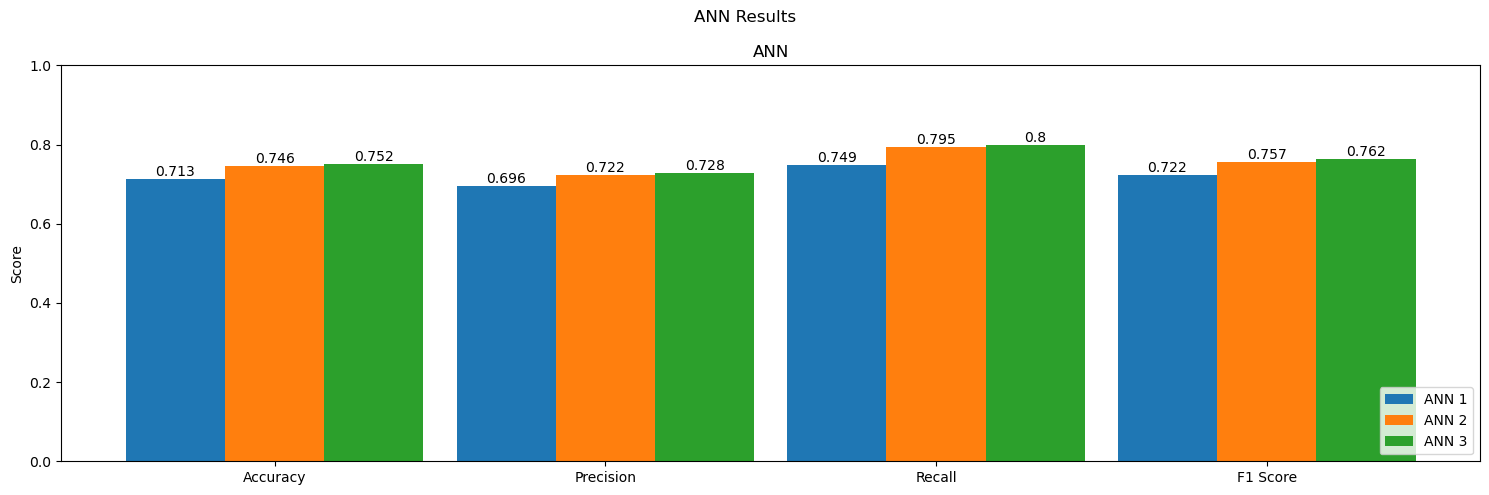

In [18]:
# Plotting
results_fig, results_ax = plt.subplots(1, 1, figsize=(15, 5))
results_fig.suptitle("ANN Results")
results_ax.bar(
    np.arange(4),
    [accuracies[0], precisions[0], recalls[0], f1_scores[0]],
    width=0.3,
    label=f"ANN 1",
)
results_ax.bar(
    np.arange(4) + 0.3,
    [accuracies[1], precisions[1], recalls[1], f1_scores[1]],
    width=0.3,
    label=f"ANN 2",
)
results_ax.bar(
    np.arange(4) + 0.6,
    [accuracies[2], precisions[2], recalls[2], f1_scores[2]],
    width=0.3,
    label=f"ANN 3",
)
results_ax.set_xticks(np.arange(4) + 0.3)
results_ax.set_xticklabels(["Accuracy", "Precision", "Recall", "F1 Score"])
results_ax.set_ylabel("Score")
results_ax.set_ylim([0, 1])
results_ax.set_title(f"ANN")
results_ax.legend(loc="lower right")

results_ax.text(0, accuracies[0], round(accuracies[0], 3), ha="center", va="bottom")
results_ax.text(1, precisions[0], round(precisions[0], 3), ha="center", va="bottom")
results_ax.text(2, recalls[0], round(recalls[0], 3), ha="center", va="bottom")
results_ax.text(3, f1_scores[0], round(f1_scores[0], 3), ha="center", va="bottom")
results_ax.text(0.3, accuracies[1], round(accuracies[1], 3), ha="center", va="bottom")
results_ax.text(1.3, precisions[1], round(precisions[1], 3), ha="center", va="bottom")
results_ax.text(2.3, recalls[1], round(recalls[1], 3), ha="center", va="bottom")
results_ax.text(3.3, f1_scores[1], round(f1_scores[1], 3), ha="center", va="bottom")
results_ax.text(0.6, accuracies[2], round(accuracies[2], 3), ha="center", va="bottom")
results_ax.text(1.6, precisions[2], round(precisions[2], 3), ha="center", va="bottom")
results_ax.text(2.6, recalls[2], round(recalls[2], 3), ha="center", va="bottom")
results_ax.text(3.6, f1_scores[2], round(f1_scores[2], 3), ha="center", va="bottom")


plt.tight_layout()
plt.show()

In [89]:
print(device)
print("Test")

cpu
